# Homework 1

### Due Date: Thursday, September 13, 2018

### Getting Started

If you haven't installed Flow onto your computer at this point, it's highly recommended that you go to https://berkeleyflow.readthedocs.io/en/latest/flow_setup.html and follow the instructions to do so.
A few key points:
- This course is done in Python 3 and code in Python 2 will not be supported. Please upgrade if you haven't.
- It is highly recommended that you perform the installation in a virtual environment such an Anaconda.

# Question 1: Markov Decision Processes

Markov decision problems (MDPs) are an important prelude to all reinforcement learning applications, as they define the task space of the application in question. These MDPs consist of a tuple ($\mathcal{S}$, $\mathcal{A}$, $\mathcal{P}$, $r$), where:

- $\mathcal{S} \in \mathbb{R}^n$ is an $n$ dimensional state space
- $\mathcal{A} \in \mathbb{R}^m$ is an $m$ dimensional action space
- $\mathcal{P} : \mathcal{S} \times \mathcal{A} \times \mathcal{S} \to \mathbb{R}_+$ is a transition probability function
- $r : \mathcal{S} \to \mathbb{R}$ is a reward function

Note that MDPs are often characterized with other properties as well (e.g. a time horizon $T$), but for this problem we will consider the above representation.

### a. Fully autonomous intersections

Consider the fully autonomous intersection problem in the figure below, where vehicles are attempting to cross an intersection from either sides. In this problem, all vehicles in the network are fully autonomous and are equipped with sensors that can provide an arbitrary amount of state information. The objective is to develop a control strategy whereby all vehicles may pass the intersection as quickly as possible without colliding into one another.

<img src="img/two_way_intersection.png" width="400">

Given the above description, design an MDP that can be used to represent the above system.

### b. "Markov" decision process?

Is the MDP you designed in section a) truly Markovian? Why or why not?

### c. Mixed autonomy intersections

Let as now consider an modification to the problem presented in section a) where only a subset of the vehicles are autonomous, while the rest are driven by humans and do not communicate with the autonomous vehicles. How does the inclusion of human vehicles affect the MDP presented in section a)? Is this problem Markovian? If not, what can be changed to make it Markovian?

$$\textbf{Student Solutions to Question 1}$$
$$\textbf{a.}$$ First, we must be rigorous on deciding what the agent is. As given in piazza the whole system becomes the agent, and our actions and transitions are given by what the whole system experiences. 

$$\mathcal{S} = x_{car}, v_{car}, a_{car}$$ for EVERY car in the system. These state features can be used to compute auxillary features such as the headway between each car, and the relative speed. We can include those features in our state too, if we wish.

$$\mathcal{A} = \mathbb{R}^n$$ where $n$ is the number of cars in the system. Each vector entry will represent the acceleration, positive or negative, of a car. This may not be the TRUE acceleration of the car, but it will be the value that the controller inputs to achieve a theoretical acceleration of $a$, assuming absolute ideal deterministic conditions

The value of the position of $\mathcal{A}$ can be given by the transition function which will be a continuous probability density function. The expected value of the pdf will be $$x_0 + \frac{1}{2}a\Delta t^2 + v_0\Delta t$$ given by mechanics, assuming no jerk (ie acceleration during this $\Delta t$ discrete time sampling will be constant). Any random variable of noise can be thought as a random variable with mean 0, added to this deterministic signal, with variance $\sigma^2$. This defines a continuous probability distribution function, where we can give probability masses only to AREAS or intervals that the car could be in. Let the PDF that represents $X \sim \mathcal{N}(0, \sigma^2)$ be $f(x)$. Then, we have that $$\mathcal{P} = \int\limits_{x_0}^{x_f}{f(x)}$$

The reward $\mathcal{r}: \mathcal{S} \rightarrow \mathbb{R}$ is $+1$ for every car through the intersection -eg the throughput. The maximum amount of positive reward can be only the number of cars in the system $n$. Therefore, settings a negative reward for every collision prohibitively higher in magnitude than $n$ eg $Nn$ for large $N$, will ensure that simply doing nothing (moving no cars) is more optimal than a single collision. This is a similar idea to duality and reforming a constraint into the objective function.


$$\textbf{b.}$$ In the purely autonomous case where you know all time derivatives of all the cars, then yes it is Markovian since you can simply use all the time derivatives of each car and solve the differential equation to know the path of the next state, given some pertubations. Sometimes the pertubation may be determined by prior incidents (eg crashes or weather that is not Markovian) - in this case it is not Markovian. However we can assume ideal conditions and optimal policies that prevent crashing.


$$\textbf{c.}$$ There is now greater uncertainty introduced. $\mathcal{S}$ and actiosn $\mathcal{A}$ will stay the same for the cars that ARE controlled by the system. However, human drivers can be suboptimal frequently and we don't know their behavior. Therefore, the transition function (in RL we need to learn this from supervised data! Learn the probability distributions) will depend on observations of past behavior of each human driver individually.

In this sense, it is not Markovian since past behavior defines the actions - humans are generally not Markovian and we have memories. Some humans may drive with a grudge or bias against other drivers/autonomous vehicles. We have simply try our best to estimate a probability distribution on the condition ONLY with the states and the probability we end up in another state given the action and given the initial state. Eventually this will converge into one conditional distribution $p(s_{t+1}|s_t,a_t)$

# Question 2: Simulating and Stabilizing Traffic in a Ring Road

In this problem, we will consider the problem of stabilizing traffic in a straight highway while using a ring road network as a surrogate. The formation of traffic instabilities (often referred to as traffic congestion, stop-and-go traffic, traffic waves, etc.) in ring roads is a widely studied problem, as it is analytically tractable and has been empirically shown to generate similar instabilities in field studies (see [this video](https://www.youtube.com/watch?v=7wm-pZp_mi0)) as those witnessed in real network settings such as highways (see [this video](https://www.youtube.com/watch?v=6ZC9h8jgSj4)). A thorough explanation of these instabilities is left until later in the course; instead here we are interested in reproducing them in simulation and we will build a few controllers to try to counteract these instabilities.

We will simulate the performance of vehicles in a ring road using the microscopic traffic simulator SUMO. In order to setup a ring road network in SUMO and study the performance of different car-following models and controllers, we will use the computational framework Flow.

### a. Modeling microscopic car-following dynamics

We begin by implementing a car-following model that can recreate the types of traffic instabilities experienced in reality. Several car-following models exist to realistically depict the longitudinal (acceleration) behavior of vehicles in a network. One such model is the Intelligent Driver Model (IDM), in which the acceleration $a_{IDM}$ of a vehicle is defined as:

\begin{equation}
a_{IDM}(v, v_l, h) = a \bigg[ 1 - \bigg( \frac{v}{v_0} \bigg) ^\delta - \bigg( \frac{s^* (v, v_l)}{h} \bigg)^2 \bigg]
\end{equation}

where $v$ the vehicle's speed, $h$ is its bumper-to-bumper headway, $v_l$ is the speed of the vehicle ahead of it, and $s^*$ is the desired headway of the vehicle, denoted by:

\begin{equation}
s^*(v, v_l)  = s_0 + \max \bigg( 0, v T + \frac{v (v - v_l)}{2 \sqrt{ab}}  \bigg)
\end{equation}

where $s_0$, $v_0$, $T$, $\delta$, $a$, $b$ are given parameters that may be calibrated to model highway traffic.

Using the *BaseController* class in Flow, design a controller that can recreate the behavior of this model in simulation. You can create this controller class by filling in the below script. Use the following values for each of the model parameters:

- $s_0$: 2 m
- $v_0$: 30 m/s
- $T$: 1 s
- $\delta$: 4
- $a$: 1 m/s$^2$
- $b$: 1.5 m/s$^2$

For more information of designing controllers in Flow, we recommend you review this [tutorial](https://github.com/berkeleyflow/flow/blob/master/tutorials/tutorial07_controllers.ipynb). **Note**: You are allowed to import any module you find valuable.

In [243]:
from flow.controllers import BaseController
#added
import numpy as np

class IDM(BaseController):
    
    #added method (not sure if necessary)
    def __init__(self, veh_id, v0=30, T=1, a=1, b=1.5, 
                 delta=4, s0=2, s1=0, time_delay=0.0, 
                 dt=0.1, noise=0, fail_safe=None, sumo_cf_params=None):
        """Docstring eliminated here for brevity"""
        BaseController.__init__(self, veh_id, sumo_cf_params,
                                delay=time_delay, fail_safe=fail_safe,
                                noise=noise)
        #initiate hyperparams (params with more meta context)
        #initial desired headway of vehicle 
        self.s0 = 2
        
        #initial veloctiy to start simulation
        self.v0 = 30
        
        #Headway calibration deterining weight of current speed for headway (time reaction)
        self.T = 1
        
        #exponential of decreasing acceleration due to current velocity
        self.delta = 4
        
        #base acceleration
        self.a = 1
        
        #proportionality constant for high relative speed added headway
        self.b = 1.5
        
        #desired headway function
        
        self.v0 = v0
        self.T = T
        self.a = a
        self.b = b
        self.delta = delta
        self.s0 = s0
        self.s1 = s1
        self.dt = dt
        

    def get_accel(self, env):
        # bumper-to-bumper headway
        h = env.vehicles.get_headway(self.veh_id)

        # speed of the current vehicle
        v = env.vehicles.get_speed(self.veh_id)

        # speed of the lead vehicle
        v_l = env.vehicles.get_speed(env.vehicles.get_leader(self.veh_id))

        ######################################
        ###### your implementation here ######
        # as it sees fit at these points.
        lead_id = env.vehicles.get_leader(self.veh_id)
        if abs(h) < 1e-3: #avoids div by 0
            h = 1e-3

        if lead_id is None or lead_id == '':  # no car ahead
            s_star = 0
        else:
            s_star = self.s0 + max(0, 
                                   v * self.T + v*(v-v_l) / (2*np.sqrt(self.a*self.b)))        
        acceleration = self.a*(1 - np.power((v/self.v0), self.delta) -  np.power((s_star/h),2))
        ######################################
        ######################################

        # return the acceleration of the current vehicle
        return acceleration

### b. Preparing the simulation

Next, we will run the simulation in SUMO using the *SumoExperiment* class in Flow. This class allows us to specify the type of scenario we would like to simulate as well as the longitudinal and lateral dynamics of vehicles in the simulation. Referring to the [tutorial in Flow on simulating traffic](https://github.com/berkeleyflow/flow/blob/master/tutorials/tutorial01_sumo.ipynb), fill in the below parameters in order to produce an experiment with a single lane ring road network of length 260 m with a total of 22 vehicles following the IDM model from part a), where the vehicles are initially perturbed from equal spacing by an additive random normal term with standard deviation 1.0 m.

In [244]:
# some objects we will use to define the parameters of the simulation
from flow.core.params import EnvParams, SumoParams, NetParams, InitialConfig
from flow.core.vehicles import Vehicles

from flow.scenarios.loop.loop_scenario import ADDITIONAL_NET_PARAMS #added from tutorial

# these are the scenario and generator classes for the ring road (they do not need to be modified)
from flow.scenarios.loop.loop_scenario import LoopScenario
from flow.scenarios.loop.gen import CircleGenerator

# this is the environment we will be using during the simulation (it does not need to be modified)
from flow.envs.test import TestEnv

# the EnvParams object is left empty for the above environment (this does not need to be modified)
env_params = EnvParams()

#from flow.controllers.car_following_models import IDMController #import IDM Controller (added)
from flow.controllers.routing_controllers import ContinuousRouter



######################################################
############ modify everything below here ############
######################################################

# add 22 vehicles with the "IDM" acceleration controller from section a)
vehicles = Vehicles()
vehicles.add("human",
             acceleration_controller=(IDM, {}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=22)
 ### modify this function call ###

# modify the NetParams object to support a ring road of length 230 m
net_params = NetParams(additional_params=ADDITIONAL_NET_PARAMS)  ### modify this class instantiation ###

# start all vehicles with perturbation standard deviation of 1.0 m
initial_config = InitialConfig(spacing="uniform", perturbation=0)  ### modify this class instantiation ### 
#second run no perturbation

# run the simulation with a simulation step of 0.1s and activate the GUI for visualization purposes
sumo_params = SumoParams(sim_step=0.1, sumo_binary="sumo-gui")  ### modify this class instantiation ###

Once the above parameters are ready, we can start the simulation using the code snippet below to see how well the network performs when the vehicles are initially perturbed. If your model and network are designed correctly, then after some time the vehicles should begin bunching together and accelerating quickly when they are at the front of the backwards propagating queue. This is known as a "stop-and-go wave".

In [245]:
from flow.core.experiment import SumoExperiment

scenario = LoopScenario(name="ring_road",
                        generator_class=CircleGenerator,
                        vehicles=vehicles,
                        net_params=net_params,
                        initial_config=initial_config)

env = TestEnv(env_params, sumo_params, scenario)

exp = SumoExperiment(env, scenario)
info_dict = exp.run(1, 3000)

print("------------------")
print("Average speed in final time step: {} m/s".format(info_dict["velocities"][0][-1]))

Round 0, return: 0
Average, std return: 0.0, 0.0
Average, std speed: 3.4169738608644606, 0.0
------------------
Average speed in final time step: 3.4540661790240335 m/s


Fill in the variable **v_perturbed** below to get the the average speed of all vehicles in the network at the end of the simulation when the vehicles are perturbed. Then, rerun the above simulation when the initial perturbation is set to 0.0 m, and fill in **v_nonperturbed** with this value.

In [246]:
# average speed of all vehicles in the network at the end of the simulation when the vehicles are perturbed
v_perturbed =  2.381582250518761#m/s

# average speed of all vehicles in the network at the end of the simulation when the vehicles are not perturbed
v_nonperturbed = 3.4540661790240335 #m/s

### c. Designing a stabilizing controller

The perturbed a non-perturbed average speeds above given us a sense of how well the scenario can perform in the presence and absence of disturbances, respectively. Autonomous vehicles present a means of potentially alleviating the negative effects of the initial perturbation. Several approaches have been recommended to do so, some of which can roughly be reduced to:

- Drive at a speed close to but below the optimal speed (v_nonperturbed).
- Try to drive halfway between vehicle in front and behind.
- Accelerate and decelerate slowly so as not to return to the location of the wave before it has partially been attenuated.

Taking inspiration from these recommendations, or from your own understanding of the problem, design a controller in the code snippet below that can improve the performance of the network in terms of the final attained average velocity using only the speed of the ego vehicle and the speeds and bumper-to-bumper gaps with the lead and lag vehicles.

In [279]:
from flow.controllers import BaseController


class StabilizingController(BaseController):

    def get_accel(self, env):
        # speed of the current vehicle
        v = env.vehicles.get_speed(self.veh_id)

        # bumper-to-bumper headway with the lead vehicle
        h = env.vehicles.get_headway(self.veh_id)

        # speed of the lead vehicle
        v_l = env.vehicles.get_speed(env.vehicles.get_leader(self.veh_id))

        # bumper-to-bumper headway with the lag vehicle
        h_lag = env.vehicles.get_headway(env.vehicles.get_follower(self.veh_id))

        # speed of the lag vehicle
        v_lag = env.vehicles.get_speed(env.vehicles.get_follower(self.veh_id))

        ######################################
        ###### your implementation here ######
        """
        #i just use IDM with different parameters here
        #lower a and b so as to achieve a larger magnitude of s_star
        #this will severely DECREASE acceleration so as to not crash the one in front; keeping it stable
        #initiate hyperparams (params with more meta context)
        #initial desired headway of vehicle
        """
        '''
        Draft 1: just do IDM with same parameters lol
        '''
        '''
        self.s0 = 2
        
        #initial veloctiy to start simulation
        self.v0 = 30
        
        #Headway calibration deterining weight of current speed for headway (time reaction)
        self.T = 1
        
        #exponential of decreasing acceleration due to current velocity
        self.delta = 4
        
        #base acceleration
        self.a = 1
        
        #proportionality constant for high relative speed added headway
        self.b = 1.5
        
        #desired headway function
        ######################################
        ######################################
        lead_id = env.vehicles.get_leader(self.veh_id)
        if abs(h) < 1e-3: #avoids div by 0
            h = 1e-3

        if lead_id is None or lead_id == '':  # no car ahead
            s_star = 0
        else:
            s_star = self.s0 + max(0, 
                                   v * self.T + v*(v-v_l) / (2*np.sqrt(self.a*self.b)))        
        acceleration = self.a*(1 - np.power((v/self.v0), self.delta) -  np.power((s_star/h),2))
        # return the acceleration of the current vehicle
        return acceleration'''
        '''
        Draft 2: Do what the hints say. 
        '''
        T = 0.1
        chase_opt = (v_nonperturbed - v)/T
        #maintain the same headway, and stay roughly in middle of front and behind cars
        #1/aT^2 = avg position of front and back = 1/2(v_lT + h_l + v_lagT - h_lag)
        staymid = (v_l + v_lag)/T + (h-h_lag)/T**2
        combo = 0.001*staymid + 0.999*chase_opt #linear combination that has sum(weights) = 1. turns out that chasing optimum 
        #is BETTER than just saying in middle, as all will have UNIFORM VEL DISTRIBUTION. this is determined only empirically not theoretically
        acceleration = 0.7*combo #regularizes ie makes acceleration less and more stable
        return acceleration

Finally, run the below script to see how well your controller performs. You may use this simulation and the resulting plot to adjust the parameters of your hand-designed controller.

Round 0, return: 0
Average, std return: 0.0, 0.0
Average, std speed: 3.4283563787908062, 0.0


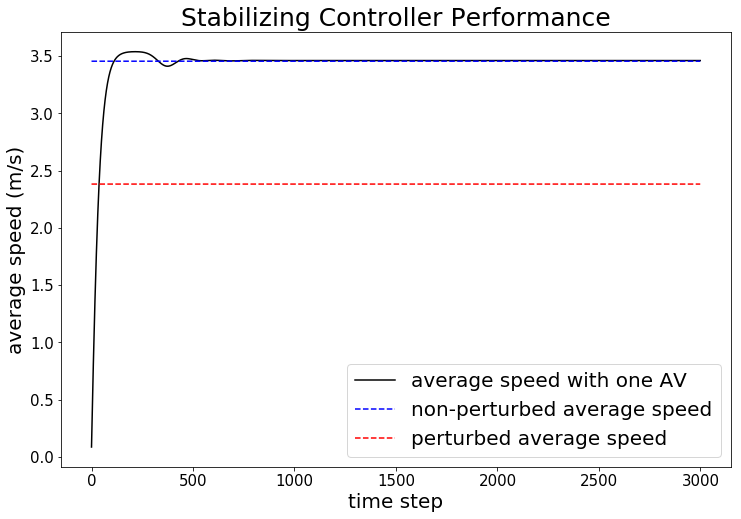

In [280]:
##########################################
######## Simulating AV controller ########
##########################################

# length of one simulation, in time steps
NUM_STEPS = 3000

# we now have 21 vehicles using the IDM model and one using the above AV controller
vehicles = Vehicles()
vehicles.add(veh_id="human", 
             acceleration_controller=(IDM, {}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=21)
vehicles.add(veh_id="AV", 
             acceleration_controller=(StabilizingController, {}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=1)

# the scenario and environment remain the same
scenario = LoopScenario(name="ring_road",
                        generator_class=CircleGenerator,
                        vehicles=vehicles,
                        net_params=net_params,
                        initial_config=initial_config)

env = TestEnv(env_params, sumo_params, scenario)

exp = SumoExperiment(env, scenario)
info_dict = exp.run(1, NUM_STEPS)


##########################################
############ Plotting results ############
##########################################

import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.title("Stabilizing Controller Performance", fontsize=25)
plt.xlabel("time step", fontsize=20)
plt.ylabel("average speed (m/s)", fontsize=20)
plt.plot(info_dict["velocities"][0], c='k', label="average speed with one AV")
plt.plot([v_nonperturbed] * NUM_STEPS, '--', c='b', label="non-perturbed average speed")
plt.plot([v_perturbed] * NUM_STEPS, '--', c='r', label="perturbed average speed")
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### d. Checking the generalizability of the controller

Now that we have designed a control strategy that can at least somewhat dissipate the formation of waves in a 260 m ring road with 22 vehicles following a deterministic car-following model, let us consider a more difficult representation of the problem. In the below cell, we place the above controller on a denser 230 m ring road where the accelerations dictated to the individual vehicles by the Intelligent Driver Model are augmented by an additional exongenuous gaussian term $\mathcal{N} \sim (0, 0.2)$ to model the stochasticity of human driver behavior.

Run the below cell (**note**: you do not have to modify your controller for this problem). Then, list 1-2 potential deficiencies of your controller. Some questions you may want to ask yourself include:
- Is your controller generalizable enough to handle this new setting? 
- Is it transferable, for instance, to straight highways, and networks with multiple lanes were vehicles can move laterally as well?

Round 0, return: 0
Average, std return: 0.0, 0.0
Average, std speed: 3.4258985390336076, 0.0


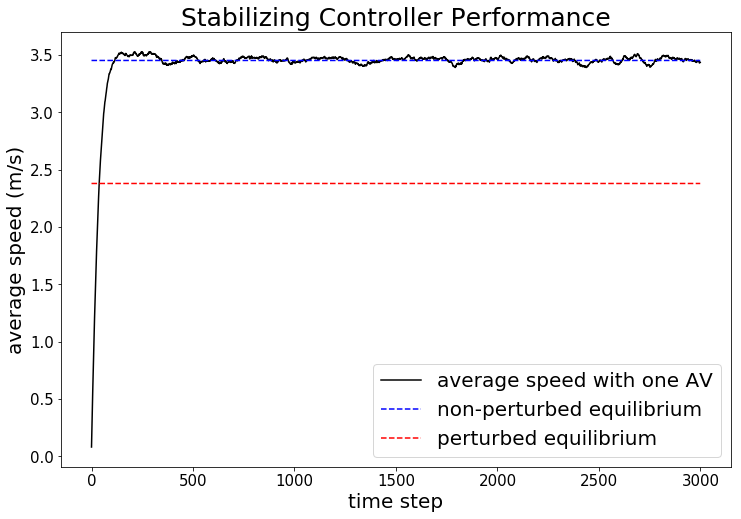

In [281]:
#########################################################
######## Simulating AV controller in new setting ########
#########################################################

# length of one simulation, in time steps
NUM_STEPS = 3000

# we now have 21 vehicles using the IDM model and one using the above AV controller
vehicles = Vehicles()
vehicles.add(veh_id="human", 
             acceleration_controller=(IDM, {"noise": 0.2}),  # the "noise" term is used to add exogenous noise
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=21)
vehicles.add(veh_id="AV", 
             acceleration_controller=(StabilizingController, {}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=1)

# we modify the length of the network from its net_params component
net_params.additional_params["length"] = 230

# all other components of the scenario and environment remain the same
new_scenario = LoopScenario(name="ring_road",
                            generator_class=CircleGenerator,
                            vehicles=vehicles,
                            net_params=net_params,
                            initial_config=initial_config)

env = TestEnv(env_params, sumo_params, new_scenario)

exp = SumoExperiment(env, new_scenario)
info_dict = exp.run(1, NUM_STEPS)


##########################################
############ Plotting results ############
##########################################

# v_perturbed and v_nonperturbed for this problem are different,
# however, they can be calculated in the same way
v_perturbed_new = 2.380637680521127
v_nonperturbed_new = 3.4540661790240335

import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.title("Stabilizing Controller Performance", fontsize=25)
plt.xlabel("time step", fontsize=20)
plt.ylabel("average speed (m/s)", fontsize=20)
plt.plot(info_dict["velocities"][0], c='k', label="average speed with one AV")
plt.plot([v_nonperturbed_new] * NUM_STEPS, '--', c='b', label="non-perturbed equilibrium")
plt.plot([v_perturbed_new] * NUM_STEPS, '--', c='r', label="perturbed equilibrium")
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

$$\textbf{Student responses}$$

Is your controller generalizable enough to handle this new setting?

Based on the results, yes, but maybe less greedy approaches should be used. We should also calculate probabilities and variances of the next car's position due to the additional noise, and then choose a safer strategy that may have less pertubation and velocity variance.

Is it transferable, for instance, to straight highways, and networks with multiple lanes were vehicles can move laterally as well?

Yes I believe more so, since one person slowing down will not cause a loop effect, and rather just influence those behind. Those behind can then split themselves among lanes, easing the traffic flow.



Weaknesses:  Main one is that it's too greedy. The cars in front don't have to follow out policy, so if one slows us down then the rest will slow down in a chain reaction. The staying in the middle is a good policy to follow to regularize this, as does our 0.7 regularization of the acceleration to slow it down a little to prevent instability. Some improvements could be made taking advantage of larger headways for example, and thus one car slowing down will not immediately force the next car to stay in the middle and be slow and instead go into the headway a little bit. We need to account for humans slowing everything down!




# Question 3: Value/Bellman Iteration
Value iteration is a key idea that underlies a lot of reinforcement learning, in particular Q-Learning, which 20 years later is still an incredibly popular algorithm. To make sure that you have a good understanding of value iteration as a solution to the Bellman equation, this exercise takes you through three ways of solving the Bellman equations.

Let's take an over-simplified traffic light example. Imagine you have a two-way intersection with traffic travelling only North-South or East-West (similar to question 1). Because traffic can only flow in one direction at a time, whenever the light is green in one direction a queue will begin to form in the other. To keep the number of states small, let us characterize the queues that form as either High (corresponding to large number of vehicles) or Low (corresponding to very few vehicles in the queue). The state space of this problem is then:

\begin{equation}
\mathcal{S}: \{\text{Low-Low, Low-High, High-Low, High-High}\}
\end{equation}

where the first element is associated with the North-South queue and the second with the East-West queue. 

Treating the controllable agents in the problem as the traffic lights at the intersection, the actions are simply to switch the state of the traffic light to be green on either the North-South ($\updownarrow$) or East-West ($\leftrightarrow$) directions:

\begin{equation}
\mathcal{A}: \{ \updownarrow, \leftrightarrow \}
\end{equation}

In this situation, we want to minimize total queue formation; subsequently, we formulate our reward $R(s,a)$ as

$$
\begin{array}{|c|c|c|}
\hline 
 s                & a & R(s,a) \\
\hline
 \text{Low-Low}   & \updownarrow / \leftrightarrow & 3 \\ \hline
 \text{High-Low}  & \updownarrow / \leftrightarrow & 2 \\ \hline
 \text{Low-High}  & \updownarrow / \leftrightarrow & 2 \\ \hline
 \text{High-High} & \updownarrow / \leftrightarrow & 1 \\ \hline
\end{array}
$$

In order to model the dynamics of the intersection, we will use a simplistic stochastic transition function $P(s' | s, a)$. Note that the true transition function is probably a good deal more complicated.

$$
\begin{array}{|c|c|c|c|}
\hline
s' & s & a & P(s'|s,a)\\ \hline
\text{Low-High}  & \text{Low-Low}   & \updownarrow & 0.5  \\ \hline
\text{Low-Low}   & \text{Low-Low}   & \updownarrow & 0.5  \\ \hline
\text{High-Low}  & \text{Low-Low}   & \leftrightarrow & 1.0  \\ \hline
\text{High-High} & \text{High-Low}  & \updownarrow & 0.25 \\ \hline
\text{Low-High}  & \text{High-Low}  & \updownarrow & 0.25 \\ \hline
\text{Low-Low}   & \text{High-Low}  & \updownarrow & 0.5  \\ \hline
\text{High-Low}  & \text{High-Low}  & \leftrightarrow & 1.0 \\ \hline
\text{High-Low}  & \text{Low-High}  & \leftrightarrow & 1.0 \\ \hline
\text{Low-High}  & \text{Low-High}  & \updownarrow & 1.0 \\ \hline
\text{Low-High}  & \text{High-High} & \updownarrow & 1.0 \\ \hline
\text{High-Low}  & \text{High-High} & \leftrightarrow & 1.0 \\ \hline
\end{array}
$$

### a. Explicit solutions of the Bellman equations
The analytic form of the solution to the Bellman equations is:

$$V^*(s) = \underset{a}{\text{max}} \ \left[R(s,a) + \gamma \sum_{s'}P(s'|s,a)V^*(s')\right]$$

Because of the "max" argument on the outside, this problem is non-linear and very difficult to solve analytically. However, if instead we want to just solve for the value function with respect to a fixed policy, then the maximization term disappears and we can instead solve a linear set of equations.

Consider the following policy $\pi$:
$$
\begin{array}{|c|c|}
\hline 
 s & \pi(s) \\
\hline
 \text{Low-Low} & \updownarrow \\ \hline
 \text{High-Low} & \updownarrow \\ \hline
 \text{Low-High} & \leftrightarrow \\ \hline
 \text{High-High} & \updownarrow \\ \hline
\end{array}
$$

Set up a set of linear equations that can be used to solve for the value function $V^\pi$ for each of the four states.

$$\textbf{STUDENT SOLUTION FOR PART A}$$
$$V^{\pi}(\text{Low-Low}) = R(\text{Low-Low}, \updownarrow) + \gamma \sum_{s'}P(s'|\text{Low-Low}, \updownarrow)V^{\pi}(s')\\
V^{\pi}(\text{High-Low}) = R(\text{High-Low}, \updownarrow) + \gamma \sum_{s'}P(s'|\text{High-Low}, \updownarrow)V^{\pi}(s')\\
V^{\pi}(\text{Low-High}) = R(\text{Low-High}, \leftrightarrow) + \gamma \sum_{s'}P(s'|\text{Low-High}, \leftrightarrow )V^{\pi}(s')\\
V^{\pi}(\text{High-High}) = R(\text{High-High}, \updownarrow) + \gamma \sum_{s'}P(s'|\text{High-High}, \updownarrow)V^{\pi}(s')$$

simplifying, we obtain:


$$V^{\pi}(\text{Low-Low}) = 3 + \gamma (0.5V^{\pi}(\text{Low-High}) + 0.5V^{\pi}(\text{Low-Low}))\\
V^{\pi}(\text{High-Low}) = 2 + \gamma (0.25V^{\pi}(\text{High-High}) + 0.25V^{\pi}(\text{Low-High}) + 0.5V^{\pi}(\text{Low-Low}))\\
V^{\pi}(\text{Low-High}) =2 + \gamma V^{\pi}(\text{High-Low}) \\
V^{\pi}(\text{High-High}) = 1 + \gamma V^{\pi}(\text{Low-High}) $$

This is a system of 4 equations and 4 variables (linearly independent) so can be analytically determined given a $\gamma$ value.

### b. Value iteration
Now, suppose we want to solve for the value function for the optimal policy. Denoting the initial value function as $V^0(s)$, initialize the value function as $V^0(s) = R(s)$, and perform one round of policy iteration to compute $V^1(s)$. Assume a discount value $\gamma = 0.5$.


$$\textbf{STUDENT SOLUTION FOR PART B}$$
$$
\begin{array}{|c|c|}
\hline 
 s & V^{0}(s) \\
\hline
 \text{Low-Low} & 3 \\ \hline
 \text{High-Low} & 2 \\ \hline
 \text{Low-High} & 2 \\ \hline
 \text{High-High} & 1 \\ \hline
\end{array}
$$

Using $$V^{t+1}(s) = \underset{a}{\text{max}} \ \left[R(s,a) + \gamma \sum_{s'}P(s'|s,a)V^t(s')\right]$$ and choosing among the action set of \begin{equation}
\mathcal{A}: \{ \updownarrow, \leftrightarrow \}
\end{equation}

the maximum can be chosen discretely simply by searching over all possible actions (only 2), and by using all the values we have as known. Doing as such gives us

$$
\begin{array}{|c|c|}
\hline 
 s & V^{1}(s) \\
\hline
 \text{Low-Low} & 4.25 \\ \hline
 \text{High-Low} & 3.125 \\ \hline
 \text{Low-High} & 3 \\ \hline
 \text{High-High} & 2 \\ \hline
\end{array}
$$


### c. Computational solution
Computing one round of policy iteration takes quite a while by hand. So now that you've built up some intuition for it, set up some code to perform further value of iterations. Run the code until one of these two conditions are reached:

1. 150 sets of value iteration have occured.
2. The smallest change in the value function of any state is less than .01. In more mathematical terms, the termination condition is: $ \text{min }|V^t(s) - V^{t+1}(s)|<.01 \ \ \  \forall s\in \mathcal{S} $

Note that the second condition should be reached well before the first. If you're hitting the first, there's probably something wrong with your code.

In [29]:
#############################################
####### add value iteration code here #######
#############################################
#set the lowlow state as 0 index, hl = 1, lh = 2, hh = 3
GAMMA = 0.5

V_0 = [3,2,2,1]
V_t = V_0.copy()#don't point to same thing
V_tplus1 = V_t.copy() #don't point to same thing
policy = [0]*4
num_iter = 150
i=0
while i < num_iter:
    i += 1
    #just do case work for each state and choosing the actions, since coding the table will be inconvenient to begin with
    #we are already in a very limited state with few states and actions so should not be hard
    
    #update V(l,l)
    V_ll_ud = 3 + GAMMA * (0.5*V_t[0] + 0.5*V_t[2])
    V_ll_lr = 3 + GAMMA * (V_t[1])
    
    if V_ll_ud >= V_ll_lr:
        V_tplus1[0] = V_ll_ud
        policy[0] = "ud"
    else:
        V_tplus1[0] = V_ll_lr
        policy[0] = "lr"
        
    #update V(hl)
    V_hl_ud = 2 + GAMMA * (0.5*V_t[0] + 0.25*V_t[2] + 0.25*V_t[3])
    V_hl_lr = 2 + GAMMA * (V_t[1])
    
    if V_hl_ud >= V_hl_lr:
        V_tplus1[1] = V_hl_ud
        policy[1] = "ud"
    else:
        V_tplus1[1] = V_hl_lr
        policy[1] = "lr"
   
    #update V(lh)
    V_lh_ud = 2 + GAMMA * (V_t[2])
    V_lh_lr = 2 + GAMMA * (V_t[1])
    
    if V_lh_ud >= V_lh_lr:
        V_tplus1[2] = V_lh_ud
        policy[2] = "ud"
    else:
        V_tplus1[2] = V_lh_lr
        policy[2] = "lr"
        
    #update V(hh)
    V_hh_ud = 1 + GAMMA * (V_t[2])
    V_hh_lr = 1 + GAMMA * (V_t[1])
    
    if V_hh_ud >= V_hh_lr:
        V_tplus1[3] = V_hh_ud
        policy[3] = "ud"
    else:
        V_tplus1[3] = V_hh_lr
        policy[3] = "lr"
    
    #the spec said the min difference can be less than 0.01 but that doesn't guarantee that they all converge
    #aboudy said it should actually be the max difference such that they all converge, so this is what I use
    if max([vp1 - v for (vp1, v) in zip(V_tplus1, V_t)]) < 0.01:
        break
    V_t = V_tplus1.copy() #next iteration with new values; don't point to same things
    

print("number of iterations", i)
print(V_tplus1)
print(policy)


number of iterations 8
[5.3662109375, 4.2412109375, 4.1162109375, 3.1162109375]
['ud', 'ud', 'lr', 'lr']


In [30]:
print('low-low value', V_tplus1[0], 'low-low-action', policy[0])
print('high-low value', V_tplus1[1], 'high-low-action', policy[1])
print('low-high value', V_tplus1[2], 'low-high-action', policy[2])
print('high-high value', V_tplus1[3], 'high-high-action', policy[3])

low-low value 5.3662109375 low-low-action ud
high-low value 4.2412109375 high-low-action ud
low-high value 4.1162109375 low-high-action lr
high-high value 3.1162109375 high-high-action lr


In [55]:
#generalize
def value_iter(convergence_thresh=0.01, GAMMA = 0.5, max_iter=150):
    V_0 = [3,2,2,1]
    V_t = V_0.copy()#don't point to same thing
    V_tplus1 = V_t.copy() #don't point to same thing
    policy = [0]*4
    num_iter = max_iter
    i=0
    while i < num_iter:
        i += 1
        #just do case work for each state and choosing the actions, since coding the table will be inconvenient to begin with
        #we are already in a very limited state with few states and actions so should not be hard

        #update V(l,l)
        V_ll_ud = 3 + GAMMA * (0.5*V_t[0] + 0.5*V_t[2])
        V_ll_lr = 3 + GAMMA * (V_t[1])

        if V_ll_ud >= V_ll_lr:
            V_tplus1[0] = V_ll_ud
            policy[0] = "ud"
        else:
            V_tplus1[0] = V_ll_lr
            policy[0] = "lr"

        #update V(hl)
        V_hl_ud = 2 + GAMMA * (0.5*V_t[0] + 0.25*V_t[2] + 0.25*V_t[3])
        V_hl_lr = 2 + GAMMA * (V_t[1])

        if V_hl_ud >= V_hl_lr:
            V_tplus1[1] = V_hl_ud
            policy[1] = "ud"
        else:
            V_tplus1[1] = V_hl_lr
            policy[1] = "lr"

        #update V(lh)
        V_lh_ud = 2 + GAMMA * (V_t[2])
        V_lh_lr = 2 + GAMMA * (V_t[1])

        if V_lh_ud >= V_lh_lr:
            V_tplus1[2] = V_lh_ud
            policy[2] = "ud"
        else:
            V_tplus1[2] = V_lh_lr
            policy[2] = "lr"

        #update V(hh)
        V_hh_ud = 1 + GAMMA * (V_t[2])
        V_hh_lr = 1 + GAMMA * (V_t[1])

        if V_hh_ud >= V_hh_lr:
            V_tplus1[3] = V_hh_ud
            policy[3] = "ud"
        else:
            V_tplus1[3] = V_hh_lr
            policy[3] = "lr"

        #the spec said the min difference can be less than 0.01 but that doesn't guarantee that they all converge
        #aboudy said it should actually be the max difference such that they all converge, so this is what I use
        if max([vp1 - v for (vp1, v) in zip(V_tplus1, V_t)]) <= convergence_thresh: #made equal to account for 0
            print("num iter", i)
            return V_tplus1, policy
        V_t = V_tplus1.copy() #next iteration with new values; don't point to same things
    print("num iter", i)
    return V_tplus1, policy
    

In [56]:
value, optpol = value_iter(0,0.5,150)
print(value) #true optimum since converged!
print(optpol)

num iter 54
[5.375, 4.25, 4.125, 3.125]
['ud', 'ud', 'lr', 'lr']


### d. Conceptual check

Pretend for a second that the value functions you've computed above are the optimal value functions (which they would be if you ran them long enough to make the error essentially zero). Given the optimal value functions and the transition functions, how would you find the optimal policy for any given state?


Student solution: I already did that - I set the argmax of the Q value to be the optimal action of that state, in my policy vector. If I didn't do that, we can simply calculate the $Q(s,a)$ value state by state (using our optimal $V^*$ values guaranteeing that the policy is truly optimal), iterating through actions. In each state just choose the optimal action.

# Question 4: Why Stochastic Gradient Descent?

In this problem we're going to explore the value of stochastic gradient descent and answer the following question: If you know the true gradient, what's the point of using stochastic gradient descent?

Before we move on to trying out gradient descent and its variants to an interesting transportation problem, let's try a few examples to illustrate the power of gradient descent and the speed-boost we can pick up from stochastic gradient descent. 

We are trying to find a linear function that can be used to identify when a point is in one of two classes. The goal here is to find a weight vector $\vec{w} \in \mathbb{R}^n$ that we can use to classify a sample $x_i$ as label -1 if $\vec{w} \cdot \vec{x_i} > 0$ and label 1 if $\vec{w} \cdot \vec{x_i} < 0$. Geometrically, a sample is in class 1 if it is on the same side of the hyper-plane as the weight vector. 

Let's start with a low-dimensional linear-classification example. First, let's generate some data. Because of the way we generate this data, we can guarantee that it can be separated by a hyper-plane. 

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(dim, batch_size=5000, visualize=False):
    """
    Returns batch_size of vectors of length-dim, their associated labels, and the hyperplane used to generate them. 
    Labels are sampled from a random hyper-plane
    """
    weights = np.random.rand(dim)
    data = np.random.rand(batch_size, dim) - 0.5
    labels = np.zeros(batch_size)
    labels[np.dot(data, weights) > 0] = -1 #you can only do this syntax hacking with np.dot!
    labels[np.dot(data, weights) <= 0] = 1
    if visualize:
        fig = plt.scatter(data[:,0], data[:,1], c=labels, cmap='bwr')
        plt.show()
    return data, labels, weights

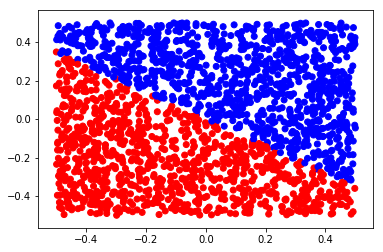

The weights of the hyper-plane are: [ 0.56253349  0.80386137]


In [7]:
data, labels, true_weight = generate_data(dim=2, batch_size=2000, visualize=True)#changed from 200 to 2000 just to make a more dense illustration
print("The weights of the hyper-plane are:", true_weight)

Now, for the purposes of illustration, we've actually returned the true weight vector but in general you might get data sampled from some random distribution and want to classify it. So, let's pretend we don't know the weight vector and attempt to recover it via gradient descent. To do so, we need a metric that tells you whether the weight vector is classifying things correctly. 
There are a lot of popular choices for loss functions, but for the purpose of simplicity let's use the following classification scheme.

Notice from the sample implementation that if a data-point $x_i$ has $\vec{w}\cdot x_i > 0$ then its label $l_i$ is -1 so define:

$$z_i = \vec{w}\cdot x_i$$

We have that $l_i z_i < 0$ for everything with label -1. The same is true for all the points with label 1! So, if we compute $z_i$ for a given point with our test weight vector and it's positive, then we've got a misclassified sample! Motivated by this, let's define the loss as 

\begin{equation}
L = \frac{1}{N} \sum_{i=0}^N L(z_i, l_i)
\end{equation}

where:

\begin{equation}
L(z_i, l_i) =
\begin{cases}
0 & l_i z_i < 0 \\
l_i z_i & l_i z_i > 0 \\
\end{cases}
\end{equation}

Now if we sum up over these, if the sum isn't zero, there's still a mis-classified point.

In [8]:
# an initial weight
w0 = np.random.rand(2)#random
#separate cell so as to not run this again! don't correupt experiement with randomness

In [178]:
def loss(weight, data, labels):
    errors =  labels * np.dot(data, weight) #NOTE: THIS DOES A HADAMARD POINTWISE, NOT DOT PRODUCT
    errors = errors[errors > 0]#get rid of and condense the negative and 0 elements so as to compute loss without them
    return 1/data.shape[0] * np.sum(errors)

# evaluate the loss to start
print(loss(w0, data, labels))
#print(w0)

0.00537673045241


Now that we've shown how to set up a classification loss and generate the data, please solve the following problems:

1. Generate a batch of 100000 data points of dimension two. For this data, compute the time to reduce the loss below .001 for batch sizes from 100 to a full batch in 10x increments. The full batch corresponds to normal gradient descent. Plot the batch-size vs. the time taken to convergence. Finally, in order to validate that your SGD operation is in fact converging to the right solution, print the normalized set of true hyper-plane parameters and the parameters you received in the 100 batch size case. **Warning**: do not recreate the data for each batch-size test as this can corrupt your results.
2. Repeat the above problem but make the dimension of the data 50. 

**Hints**: 
- You can play around with the step-size, but a good starting point is often .01
- Make sure to keep the step-size the same across batches, otherwise your comparison is invalid.

Hopefully after this you can see why stochastic gradient descent is such a beloved technique, at least from the perspective of sample efficiency.

In [96]:
#import dependencies
#EVERYTHING BELOW IS STUDENT EDITS
import datetime
import time
from sklearn.model_selection import train_test_split
import numpy.linalg

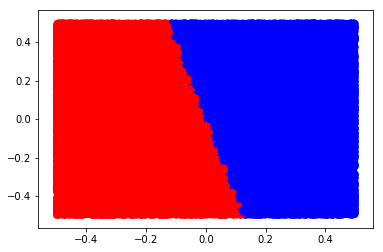

In [173]:
#################################
####### add SGD code here #######
#################################
#Generate a batch of 100000 data points of dimension two. 
data, labels, true_weight = generate_data(dim=2, batch_size=100000, visualize=True)
#Run only ONCE PER EXPERIMENT; DO NOT RERUN 

In [174]:
print(true_weight) #the optimum of our gradient descent

[ 0.9304067   0.23389626]


In [175]:
#For this data, compute the time to reduce the loss below .001 for batch sizes from 100 to a full batch in 10x increments.
STEPSIZE = 0.01

batch_sizes = [100, 1000, 10000, 100000]
#batch_sizes[3] - data.shape[0] = 0 verifies that the full batch is the last batch size

Note that the gradient of the function $$L(z_i, l_i)$$ with respect to the weight vector $$w = [w_1 w_2]^T$$ is given by the piecewise function

$$\nabla_w(L(z_i, l_i)) = \begin{cases} 0 & l_iz_i < 0 \\ l_ix_i & l_iz_i \geq 0 \end{cases}$$  

Therefore, using the linearity of the derivative and gradient operator, we have that:

$$\nabla_wL = \frac{1}{N}\sum\limits_{l_iz_i > 0}{l_ix_i}$$

In [70]:
#print(data) #visualizes the data
#print(local_loss_grad(np.array([-0.1,0.2]), data[10], labels[10]))
#print(np.add(np.array([0,0]), local_loss_grad(np.array([-0.1,0.2]), data[10], labels[10])))

[-0.45355899  0.48084134]
[-0.45355899  0.48084134]


In [188]:
def local_loss_grad(weight, data, label):
    if np.dot(weight, data)*label < 0:
        return 0
    else:
        return label*data
def gradient_of_loss(weight, data, labels):#slow
    init_grad = np.array([0,0])
    for i in range(len(labels)):
        localloss = local_loss_grad(weight, data[i], labels[i])
        init_grad = np.add(init_grad, localloss)
    total_grad = init_grad
    return total_grad/len(labels)
def gradient_of_loss_2vec(weight, data, labels):
    return sum([local_loss_grad(weight, datapt, label) for (datapt, label) in zip(data, labels)])

In [180]:
weight_init = np.random.rand(2) #from the same distribution but not the same

In [181]:
'''Playing around with the time 
start = time.time()
totsum = sum([i for i in range(100000000)])
end = time.time()
print(end-start)
For this data, compute the time to reduce the loss below .001 for batch sizes from 100 to a full batch in 10x increments.
The full batch corresponds to normal gradient descent. Plot the batch-size vs. the time taken to convergence.
'''
times = [0]*len(batch_sizes)
weights = [0]*len(batch_sizes)
for i in range(len(batch_sizes)):
    labeleddata = np.array(list(zip(data, labels)))
    batchindices = np.random.choice(len(labeleddata), batch_sizes[i], replace = False)
    batch = labeleddata[batchindices]
    batch_labels = np.array([a[1] for a in batch])
    batch_data = np.array([a[0] for a in batch])
    weight = weight_init
    start = time.clock()
    while (loss(weight, batch_data, batch_labels) > 0.001):
        gradient = gradient_of_loss_2vec(weight, batch_data, batch_labels)
        weight = np.add(weight, -STEPSIZE*gradient)
    end = time.clock()
    times[i] = end-start
    weights[i] = weight

In [183]:
normalized_weights = [w/np.linalg.norm(w) for w in weights]
print(normalized_weights)
normalized_true_weight = true_weight/np.linalg.norm(true_weight)
print(normalized_true_weight)
print("difference",[np.linalg.norm(nw - normalized_true_weight) for nw in normalized_weights])

[array([ 0.92461435,  0.38090459]), array([ 0.92461435,  0.38090459]), array([ 0.92461435,  0.38090459]), array([ 0.92461435,  0.38090459])]
[ 0.96982416  0.24380547]
difference [0.14436098495608685, 0.14436098495608685, 0.14436098495608685, 0.14436098495608685]


In [184]:
print("weights:", weights)
print("optimum weight:", true_weight)
print("times:", times)

weights: [array([ 0.66819247,  0.2752689 ]), array([ 0.66819247,  0.2752689 ]), array([ 0.66819247,  0.2752689 ]), array([ 0.66819247,  0.2752689 ])]
optimum weight: [ 0.9304067   0.23389626]
times: [5.000000055588316e-05, 7.000000005064066e-05, 0.0011020000001735752, 0.004382000000077824]


In [185]:
print(weight_init)
print(loss(true_weight, data, labels))
print(loss(weight_init, data, labels))
print([loss(weights[i], data, labels) for i in range(len(weights))])

[ 0.66819247  0.2752689 ]
0.0
0.000711023525592
[0.00071102352559152373, 0.00071102352559152373, 0.00071102352559152373, 0.00071102352559152373]


In [112]:
import matplotlib.pyplot as plt

Plots for 2 dimensional case are given below with the batch size in the x axis

Text(0,0.5,'Time, in seconds')

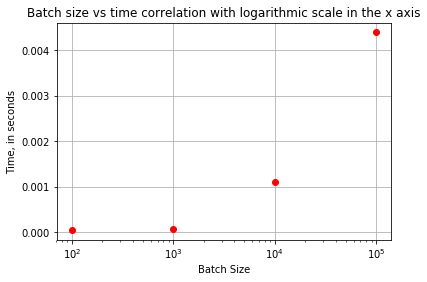

In [187]:
plt.plot(batch_sizes, times, 'ro')
plt.xscale('log')
plt.title('Batch size vs time correlation with logarithmic scale in the x axis' )
plt.grid(True)
plt.xlabel('Batch Size')
plt.ylabel('Time, in seconds')

Now, we do 50 DIMENSIONS OF SGD

In [122]:
#generate the data
#################################
####### add SGD code here #######
#################################
#Generate a batch of 100000 data points of dimension 50
data, labels, true_weight = generate_data(dim=50, batch_size=100000, visualize=False)#can't visualize 50 d accurately
#as a 2d projection does do it justice
#Run only ONCE PER EXPERIMENT; DO NOT RERUN 

In [123]:
print("Optimum weight", true_weight)

Optimum weight [ 0.44593578  0.73708697  0.83081289  0.34801974  0.73342596  0.22917023
  0.43324391  0.9008106   0.33989193  0.36861853  0.78581493  0.83802684
  0.75916086  0.74662081  0.10121134  0.89436363  0.25262807  0.26279223
  0.39516854  0.94735079  0.28928044  0.35899923  0.36069599  0.58301969
  0.6932478   0.90707319  0.89650499  0.73186624  0.12083741  0.73727048
  0.70348697  0.88263228  0.16644815  0.22417859  0.45290122  0.78733469
  0.90988357  0.90342262  0.3725944   0.06846944  0.23099891  0.66438548
  0.12195685  0.1546207   0.14355442  0.06104522  0.18033076  0.30140014
  0.73515639  0.42731735]


The gradient remains the same as before since we took the gradient WLOG to the dimension. Keep in mind here that $x_i$ is actually dimension 50 instead though

In [170]:
def local_loss_grad_50(weight, data, label):
    assert len(data) == 50, "Please make sure this is a 50 dimensional piece of data"
    if np.dot(weight, data)*label < 0:
        return np.zeros(50)#should be a vector NOT A SCALAR as it is a GRADIENT
    else:
        return label*data #in R^50
def gradient_of_loss_50(weight, data, labels):
    init_grad = np.zeros(50)
    for i in range(len(labels)):
        localloss = local_loss_grad(weight, data[i], labels[i])
        init_grad = np.add(init_grad, localloss)
    total_grad = init_grad
    return total_grad/len(labels)
def gradient_of_loss_50vec(weight, data, labels):
    return sum([local_loss_grad_50(weight, datapt, label) for (datapt, label) in zip(data, labels)])

In [157]:
#test the dimension
#local_loss_grad50(np.random.rand(50), np.random.rand(50)-0.5, 1)
#gradient_of_loss_50vec(np.ones(50), np.array([np.zeros(50), np.ones(50)]), np.array([1,-1])) #tests the vectorization

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [158]:
#ONLY RUN ONCE PER EXPERIMENT TO HAVE CONSISTENT INITIALIZATION
weight_init = np.random.rand(50) #from the same distribution but not the same vector normalized necessarily (unless you got luck)

In [159]:
times = [0]*len(batch_sizes)
weights = [0]*len(batch_sizes)
for i in range(len(batch_sizes)):
    labeleddata = np.array(list(zip(data, labels)))
    batchindices = np.random.choice(len(labeleddata), batch_sizes[i], replace = False)
    batch = labeleddata[batchindices]
    batch_labels = np.array([a[1] for a in batch])
    batch_data = np.array([a[0] for a in batch])
    weight = weight_init
    start = time.clock()
    while (loss(weight, batch_data, batch_labels) > 0.001):
        gradient = gradient_of_loss_50vec(weight, batch_data, batch_labels)
        weight = np.add(weight, -STEPSIZE*gradient)
    end = time.clock()
    times[i] = end-start
    weights[i] = weight

In [163]:
normalized_weights = [w/np.linalg.norm(w) for w in weights]
print("sgd weights", normalized_weights)
normalized_true_weight = true_weight/np.linalg.norm(true_weight)
print("optimum weight", normalized_true_weight)
print("difference",[np.linalg.norm(nw - normalized_true_weight) for nw in normalized_weights])

sgd weights [array([ 0.10320308,  0.10648944,  0.04168086,  0.09847187,  0.02501825,
       -0.05121929,  0.10414867,  0.13158953,  0.03862683,  0.05605057,
        0.08956891,  0.15091973,  0.01347815,  0.25005229,  0.09472368,
        0.19852068,  0.21753814,  0.19765463,  0.00187814,  0.27086718,
        0.06959102,  0.16532836,  0.20841258,  0.1866998 ,  0.06069443,
        0.16303261,  0.12357875,  0.18714694,  0.0865375 ,  0.25956986,
        0.09121726,  0.23381528,  0.16539728,  0.04158379,  0.16639529,
        0.18659047,  0.12817214,  0.10583202,  0.16170224,  0.20333593,
        0.0370822 ,  0.16133884,  0.02776554,  0.04291717,  0.05529186,
       -0.01641134,  0.18333613,  0.0642867 ,  0.15291236,  0.13715173]), array([ 0.11041711,  0.14176272,  0.18815476,  0.08572309,  0.14494441,
        0.0774507 ,  0.08063085,  0.23143344,  0.07393197,  0.07001405,
        0.16206357,  0.18791859,  0.17893215,  0.19704139,  0.01846431,
        0.22263698,  0.09854652,  0.08701341,  0.

In [166]:
print(weight_init)

[ 0.33376627  0.44353489  0.10570823  0.31904311  0.16205098  0.07871254
  0.32271682  0.75742986  0.27450502  0.28976539  0.0890302   0.41109421
  0.0091839   0.61761301  0.33333771  0.71857852  0.86084437  0.66729955
  0.50877068  0.98664837  0.29335515  0.4406666   0.9616375   0.9477806
  0.21157467  0.38891209  0.11437495  0.5557952   0.93426667  0.58535562
  0.17863113  0.55800081  0.71598601  0.02914185  0.57059562  0.13016384
  0.06541833  0.17616252  0.72257893  0.74964876  0.134283    0.67291383
  0.33838448  0.36725891  0.17245504  0.48303336  0.79661444  0.15204469
  0.23075031  0.57825979]


In [167]:
print(loss(true_weight, data, labels)) #should be 0
print(loss(weight_init, data, labels)) #hopefully much higher than our resultant
print([loss(weights[i], data, labels) for i in range(len(weights))]) #our resultant

0.0
0.125159341943
[0.06718400126087061, 0.0048012782221446204, 0.00088752282559905924, 0.00017753363117258645]


Text(0,0.5,'Time, in seconds')

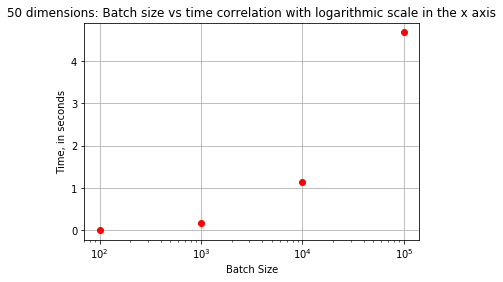

In [169]:
plt.plot(batch_sizes, times, 'ro')
plt.xscale('log')
plt.title('50 dimensions: Batch size vs time correlation with logarithmic scale in the x axis' )
plt.grid(True)
plt.xlabel('Batch Size')
plt.ylabel('Time, in seconds')